# Technical comments:
This network reads csv files (describing OpenFOAM cases) generated by foam-based utility, then build a machine model to learn the effect of case parameters (here geometry) on the solution field.

The network can be either "supervised" or "unsupervised". The inputs can be gradient coefficients (cellCoeffs) or a "mask" either of which descrinbing the geometry of the mesh.

It is concluded that the best option is to use "supervised" with "cellCoeffs".

For unsupervised:

A more complex network (with 10 times of supervised weights) is needed.

Each epoch takes as 25 times as time of each epoch in supervised.

The training process roughly reuqires 10 time as number of epoches required by supervised. 


For supervised:

If we use mask (instead of cellCoeffs) as the input, we need more samples in the training data-set for avoiding overfitting. 




In [1]:
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import pandas as pds
import pickle
from distutils.dir_util import mkpath
from multiprocessing import Pool
from time import time
import tensorflow as tf 
import math
import os
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

unsupervised = False
inputName = 'cellCoeffs'#'cellCoeffs' #'mask' #'coordinate'

from tensorflow.keras import backend as K
import timeit



In [2]:
## This is used where cells numbers for samples are not equal 
def stack_uneven(arrays, fill_value=0.):
    '''
    Fits arrays into a single numpy array, even if they are
    different sizes. `fill_value` is the default value.

    Args:
            arrays: list of np arrays of various sizes
                (must be same rank, but not necessarily same size)
            fill_value (float, optional):

    Returns:
            np.ndarray
    '''
    sizes = [a.shape for a in arrays]
    max_sizes = np.max(list(zip(*sizes)), -1)
    # The resultant array has stacked on the first dimension
    result = np.full((len(arrays),) + tuple(max_sizes), fill_value)
    for i, a in enumerate(arrays):
      # The shape of this array `a`, turned into slices
      slices = tuple(slice(0,s) for s in sizes[i])
      # Overwrite a block slice of `result` with this array `a`
      result[i][slices] = a
    return result

In [3]:
nSample = 1000

percent_train = 100

ratio=1

scaleType="variable" #"var_loc"

path=ath=os.getcwd()

In [4]:
def flat2RawShape(flatShape,maxI,maxJ):
    rawData=np.transpose(flatShape.reshape(-1,maxI*maxJ))
    return rawData

def raw2SpaceShape(rawShape,maxI,maxJ):
    dataReshaped=rawShape.reshape(maxI,maxJ,-1)
    return dataReshaped

def flat2SpaceShape(flatShape,maxI,maxJ):
    rawData=flat2RawShape(flatShape,maxI,maxJ)
    spaceShaped=raw2SpaceShape(rawData,maxI,maxJ)
    return spaceShaped

def space2RawShape(spaceShape,maxI,maxJ):
    #print(spaceShape.shape)
    rawSahped=spaceShape.reshape(maxI*maxJ,-1)
    return rawSahped

def raw2FlatShape(Shape,maxI,maxJ):
    #print(spaceShape.shape)
    flatSahped=np.transpose(Shape)[:Shape.shape[1],:].reshape(1,-1)
    return flatSahped

def scaled2Raw(scaledData,maxI,maxJ):
    with open('training_scalers.pkl','rb') as f:
        scaler_data_l = pickle.load(f)
    try:
        scaler_y=scaler_data_l['scaler_y']
        data_scaled_flat=[]
        data_scaled_raw=[]
        if scaledData.ndim<4:
            data_scaled_raw.append(space2RawShape(scaledData,maxI,maxJ))
            data_scaled_flat.append(raw2FlatShape(data_scaled_raw[0],maxI,maxJ))
        else:
            for i in range(0,scaledData.shape[0]):
                data_scaled_raw.append(space2RawShape(scaledData[i],maxI,maxJ))
                data_scaled_flat.append(raw2FlatShape(data_scaled_raw[i],maxI,maxJ))
        if scaleType=="var_loc":
            data_scaled_flat=np.concatenate(data_scaled_flat,0)
            data_flat=scaler_y.inverse_transform(data_scaled_flat)
            data_raw=np.apply_along_axis(flat2RawShape,1,data_flat,maxI,maxJ)

        elif scaleType=="variable":
            data_scaled_raw=np.concatenate(data_scaled_raw,0)
            data_raw=scaler_y.inverse_transform(data_scaled_raw)
            data_raw=data_raw.reshape(scaledData.shape[0],maxI*maxJ,-1)
    except:
        scaler_y=scaler_data_l['scaler_x']
        data_scaled_flat=[]
        data_scaled_raw=[]
        if scaledData.ndim<4:
            data_scaled_raw.append(space2RawShape(scaledData,maxI,maxJ))
            data_scaled_flat.append(raw2FlatShape(data_scaled_raw[0],maxI,maxJ))
        else:
            for i in range(0,scaledData.shape[0]):
                data_scaled_raw.append(space2RawShape(scaledData[i],maxI,maxJ))
                data_scaled_flat.append(raw2FlatShape(data_scaled_raw[i],maxI,maxJ))
        if scaleType=="var_loc":
            data_scaled_flat=np.concatenate(data_scaled_flat,0)
            data_flat=scaler_y.inverse_transform(data_scaled_flat)
            data_raw=np.apply_along_axis(flat2RawShape,1,data_flat,maxI,maxJ)

        elif scaleType=="variable":
            data_scaled_raw=np.concatenate(data_scaled_raw,0)
            data_raw=scaler_y.inverse_transform(data_scaled_raw)
            data_raw=data_raw.reshape(scaledData.shape[0],maxI*maxJ,-1)


    return data_raw
    


In [5]:
train_data_path = glob(path+'/ml_dataset/train/*/')[:nSample]
test_data_path = glob(path+'/ml_dataset/test/*/')[:nSample]

np.random.shuffle(train_data_path)
np.random.shuffle(test_data_path)

In [6]:
def readFoamData(files):
    X = []
    end = len(files)
    for i in range(0, len(files)):
        data = pds.read_csv(files[i],delim_whitespace = True).values
        X.append(data)
    X = np.stack( X, axis=0 )
    return X

def readAllFoamData(data_path):
    cellCoeffData = []
    cellNeiData = []
    bTracData = []
    bFixedData = []
    dispData = []
    bTractionDispData = []
    XData = []
    YData = []
    intrpAddrData = []
    intrpWeiData = []
    coordinatesData = []

    for i in range(0, len(data_path)):
        data = pds.read_csv(glob(data_path[i]+'/*/cellCo*.dat')[0],delim_whitespace = True).values
        cellCoeffData.append(data)
        data = pds.read_csv(glob(data_path[i]+'/*/cellNe*.dat')[0],delim_whitespace=True).values.astype(int)
        cellNeiData.append(data)
        data = pds.read_csv(glob(data_path[i]+'/*/bFix*.dat')[0],delim_whitespace = True).values
        bFixedData.append(data)
        data = pds.read_csv(glob(data_path[i]+'/*/bTrac*.dat')[0],delim_whitespace = True).values
        bTracData.append(data)
        data = pds.read_csv(glob(data_path[i]+'/*/Disp*.dat')[0],delim_whitespace = True).values
        dispData.append(data)
        
        data = pds.read_csv(glob(data_path[i]+'/*/interpAdd*.dat')[0],delim_whitespace = True).values.astype(int)
        intrpAddrData.append(data)
        data = pds.read_csv(glob(data_path[i]+'/*/interpWe*.dat')[0],delim_whitespace = True).values
        intrpWeiData.append(data)
        
        bTractionDispData.append(data)
        
        true_mesh_data = pds.read_csv(glob(data_path[i]+'/*/inputCase.dat')[0],delim_whitespace = True).values
        coordinates=true_mesh_data[:,:2]
        coordinatesData.append(coordinates)
 
        time_step_data = pds.read_csv(glob(data_path[i]+'/*/inputCaseCrt*.dat')[0],delim_whitespace = True)
        maxJ=int(time_step_data.iloc[-1]["IndexJ"]+1)
        maxI=int(time_step_data.iloc[-1]["IndexI"]+1)
        feature_columns_name=["IndexI","IndexJ"]#,"Dx","Fx"]#,"CellX","CellY","Fx","Fy"]
        popK=len(feature_columns_name)
        for kk in range(0,popK):
            popData=time_step_data.pop(feature_columns_name[kk])
        data_values=time_step_data.values
        nCol=data_values.shape[0]/2
        data_reshaped=raw2SpaceShape(data_values,maxI,maxJ)
        if scaleType=="variable":
            X_data=data_values[:,:data_values.shape[1]-2]
            Y_data=data_values[:,data_values.shape[1]-2:]
        elif scaleType=="var_loc":
            X_data=np.transpose(data_values)[:data_values.shape[1]-2,:].reshape(-1)
            Y_data=np.transpose(data_values)[data_values.shape[1]-2:,:].reshape(-1)
        XData.append(X_data)
        YData.append(Y_data)
    cellCoeffData = stack_uneven( cellCoeffData, 0.0)
    cellNeiData = stack_uneven( cellNeiData, 0 ).astype(int)
    bFixedData = stack_uneven( bFixedData, 0.0 )
    bTracData = stack_uneven( bTracData, 0.0 )
    coordinatesData = stack_uneven( coordinatesData, 0.0 )
    
    bTracData[bTracData[:,:,7] == 0,7] = 1

    dispData = stack_uneven( dispData, 0.0 )

    intrpAddrData = stack_uneven(intrpAddrData, 0 ).astype(int)
    intrpWeiData = stack_uneven(intrpWeiData, 0.0 )

    bTractionDisp = stack_uneven(bTractionDispData, 0.0 )

    if scaleType == "var_loc":
        XData = stack_uneven(XData, 0.0)
        YData = stack_uneven(YData, 0.0)
    elif scaleType=="variable":
        XData = np.concatenate(XData)
        YData = np.concatenate(YData) 

    cellCoeffData = cellCoeffData.reshape(cellCoeffData.shape[0],cellCoeffData.shape[1],-1,3)
    
    XData=XData.reshape(len(data_path),maxI,maxJ,-1)
    YData=YData.reshape(len(data_path),maxI,maxJ,-1)

    disp_true_crt = YData.reshape([-1,maxI*maxJ,2])

    if (bTracData.size == 0):
        bTracData=np.zeros([1,1,11])
        bTractionDisp = np.zeros([3])
        bTracData[0,0,7]=1.0

    return cellCoeffData, cellNeiData, bFixedData, bTracData, dispData, XData,YData,\
                intrpAddrData, intrpWeiData, maxI,maxJ, bTractionDisp,coordinatesData


cellCoeff, cellNei, bFixed, bTrac, disp_true, X,Y,intrpAddr,intrpWei, \
        maxI,maxJ, bTractionDisp, coord = readAllFoamData(train_data_path)

cellCoeff_test, cellNei_test, bFixed_test, bTrac_test, disp_true_test, X_test,Y_test,intrpAddr_test,intrpWei_test, \
        maxI_test,maxJ_test, bTractionDisp_test, coord_test = readAllFoamData(test_data_path)

   
print(bTrac.shape)
print(bFixed.shape)
print(disp_true.shape)
print(coord.shape)
print(bTrac_test.shape)
print(bFixed_test.shape)
print(disp_true_test.shape)
print(coord_test.shape)


(98, 108, 14)
(98, 8, 11)
(98, 400, 3)
(98, 400, 2)
(20, 108, 14)
(20, 8, 11)
(20, 400, 3)
(20, 400, 2)


In [7]:

scaler_y = StandardScaler()
disp_true_scaled=scaler_y.fit_transform(disp_true.reshape([disp_true.shape[0],-1])).reshape(disp_true.shape)


In [8]:
#if (inputName=='mask'):
X = np.expand_dims(X[:,:,:,2],-1)
X_test = np.expand_dims(X_test[:,:,:,2],-1)      

n_train = int(X.shape[0]/100*percent_train)


X_train = X[:n_train]
cellCoeff_train = cellCoeff[:n_train]
cellNei_train = cellNei[:n_train]
bTrac_train = bTrac[:n_train]
bFixed_train = bFixed[:n_train]
intrpWei_train = intrpWei[:n_train]
intrpAddr_train = intrpAddr[:n_train]






print(X_train.shape)

no_cell = np.ones_like(disp_true)
no_cell[(disp_true == 0)] = 0

no_cell_test = np.ones_like(disp_true_test)
no_cell_test[(disp_true_test == 0)] = 0

print(X.shape)


(98, 20, 20, 1)
(98, 20, 20, 1)


In [9]:



import os


from distutils.dir_util import mkpath
import datetime
from tensorflow.keras import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,GRU,Dropout,Conv1D,Flatten,Input,concatenate
from tensorflow.keras.layers import Conv2DTranspose,Reshape, Conv2D,MaxPooling2D,UpSampling2D

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
from scipy.stats import norm
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist


import tensorflow.keras.backend as K


In [10]:
#tf.compat.v1.disable_eager_execution()

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_gpu_available()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15945540165536906403
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16740924574135212544
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4676395601478572716
physical_device_desc: "device: XLA_GPU device"
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [12]:
# For this function, we assumed:
# a) bFix and bTrac has a same shape as cellCoeff; so we need to define a new bTrac(or bFix) for all cells
ratio1=1e0
ratio = ratio1
foam_trac=True
mu = 0.7692*ratio1
K=1.667*ratio1
impK=mu*2.5

def modifyAddressBc(bc,nCell):
    addComp0 = tf.cast(tf.range(0, tf.keras.backend.shape(bc)[0], 1)*nCell,bc.dtype)
    #print(addComp0)
    #inputBc = tf.keras.layers.Input((4))
    addComp0 = tf.expand_dims(tf.broadcast_to(tf.expand_dims(addComp0,-1),
                                              [tf.keras.backend.shape(bc)[0], bc.shape[1]]),-1)
    addComp = tf.concat([addComp0,tf.zeros_like(bc[:,:,1:])],-1)
    bcNew = bc + addComp
    #print(bcNew[:,:,0])

    return bcNew



def tracIterate(bTr,grad,phibOrg,gradInt,bSnGrad):
    n = tf.reshape(bTr[:,:,1:4],[-1,1,3])     
    bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
    ownGradD=tf.gather(grad,bcOwner,axis=0)
    deltaCoeff = tf.reshape(bTr[:,:,7],[-1,1,1])
    tangVec = tf.reshape(bTr[:,:,-3:],[-1,1,3]) 
    phib=phibOrg+bSnGrad/deltaCoeff + tf.matmul(tangVec,ownGradD)
    SfV = tf.reshape(bTr[:,:,8:11],[-1,3,1])
    bcEffect = tf.matmul(SfV,phib)
    #print("bSnGrad=",bSnGrad.eval(session=tf.compat.v1.Session()))

    bcOwner=tf.expand_dims(bcOwner,axis=-1)
    grad=tf.tensor_scatter_nd_add(gradInt,bcOwner,bcEffect)
    #print(gradInt[10].numpy())
    #print(grad[10].numpy())

    bTrac = tf.reshape(bTr[:,:,4:7]*ratio,[-1,1,3])    
    bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
    ownGradD=tf.gather(grad,bcOwner,axis=0)
    nDotOwnerGrad=tf.matmul(n,ownGradD)
    n = tf.reshape(bTr[:,:,1:4],[-1,3,1])                
    bcGradD= ownGradD + tf.matmul(n, (bSnGrad - nDotOwnerGrad))
    bcGradTranspose=tf.transpose(bcGradD, perm=[0,2,1])
    bcEps = 0.5*(bcGradTranspose+bcGradD)
    bcTraceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(bcEps),axis=-1),axis=-1)
    
    bcDevEps = bcEps - bcTraceEps*np.identity(3)/3.0
    bcSigma=2.0*mu*bcDevEps + K*bcTraceEps*np.identity(3)
    n = tf.reshape(bTr[:,:,1:4],[-1,1,3])                
    sigGrad = tf.matmul(n,(bcSigma-impK*bcGradD))
    snGrad=(bTrac-sigGrad)/impK
 



    return grad, snGrad, bcGradD

def fvc_grad(phi,cellNei,cellCoeff,bFix,bTr):
    #print(cellNei.shape)

    arrangedDisp=tf.gather(
        phi, cellNei, validate_indices=np.int64, axis=1, batch_dims=1, name=None
    )
    arrangedDisp=tf.expand_dims(arrangedDisp,axis=-2)
    arrangedCoeff=tf.expand_dims(cellCoeff,axis=-1)

    L=tf.matmul(arrangedCoeff,arrangedDisp)
    grad=tf.reduce_sum(L,axis=2)

    
    ### Apply BC  ###
    ## fixed
    SfV = tf.reshape(bFix[:,:,8:11],[-1,3,1])
    phib = tf.reshape(bFix[:,:,4:7],[-1,1,3])
    bcEffect = tf.matmul(SfV,phib)
    
    bcOwner=tf.reshape(tf.cast(bFix[:,:,0],tf.int64),[-1])

    grad=tf.reshape(grad,[-1,grad.shape[2],grad.shape[3]])#tf.transpose(grad, perm=[1,0,2,3])
    #bcEffect=tf.reshape(bcEffect,[-1,bcEffect.shape[2],bcEffect.shape[3]])#tf.transpose(bcEffect, perm=[1,0,2,3])

    bcOwner=tf.expand_dims(bcOwner,axis=-1)

    grad=tf.tensor_scatter_nd_add(grad,bcOwner,bcEffect)
    
    gradInt=grad
    ## trac
    deltaCoeff = tf.reshape(bTr[:,:,7],[-1,1,1])
    bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
    SfV = tf.reshape(bTr[:,:,8:11],[-1,3,1])
    phiOwn = tf.expand_dims(tf.gather(tf.reshape(phi,[-1,phi.shape[-1]]),bcOwner,axis=0),axis=-2)
    
    phib = tf.reshape(tf.gather(tf.reshape(phi,[-1,1,3]),bcOwner,axis=0),[-1,1,3])
    phibOrg=phib
    #print(bTr[:,17,0])

    bcEffect = tf.matmul(SfV,phib)

    #bcEffect=tf.reshape(bcEffect,[-1,bcEffect.shape[2],bcEffect.shape[3]])#tf.transpose(bcEffect, perm=[1,0,2,3]
    bcOwner=tf.expand_dims(bcOwner,axis=-1)
    grad=tf.tensor_scatter_nd_add(grad,bcOwner,bcEffect)  
    
    #step 2
    snGrad = tf.zeros_like(phib)
    grad, snGrad, trBcGradD=tracIterate(bTr,grad,phibOrg,gradInt,snGrad)
    
    for i in range(0,30):
        grad, snGrad, trBcGradD=tracIterate(bTr,grad,phibOrg,gradInt,snGrad)
    

    #grad=tf.transpose(gradInt, perm=[1,0,2,3])
    #print(grad[45].numpy())
    trBcGradD = tf.reshape(trBcGradD,[-1,bTr.shape[1],3,3])
    grad = tf.reshape(grad,[-1,phi.shape[1],3,3])
    #print(grad[:,:6].numpy())


    #print('TimeGrad_BC: ', stop - start)
    return grad, trBcGradD
    
        
def fvc_div(phi,D,gradD,K,mu,cellNei,cellCoeff,bFix,bTr,trBcGradD):
    #start = timeit.default_timer()
    arrangedPhi=tf.gather(
        phi, cellNei, validate_indices=None, axis=1, batch_dims=1, name=None
    )
    
    arrangedCoeff=tf.expand_dims(cellCoeff,axis=-2)    
    L=tf.matmul(arrangedCoeff,arrangedPhi)
    div=tf.reduce_sum(L,axis=2)  # loop over neighbor cells

  
    # Apply BC
    bcOwner=tf.reshape(tf.cast(bFix[:,:,0],tf.int64),[-1])
    DOwner=tf.gather(tf.reshape(D,[-1,D.shape[-1]]),bcOwner,axis=0)

    ownGradD=tf.gather(tf.reshape(gradD,[-1,gradD.shape[-2],gradD.shape[-1]]),bcOwner,axis=0)
    deltaCoeff = tf.reshape(bFix[:,:,7],[-1,1])
    n = tf.reshape(bFix[:,:,1:4],[-1,1,3])                
    SfV = tf.reshape(bFix[:,:,8:11],[-1,1,3])
    Db = tf.reshape(bFix[:,:,4:7],[-1,3])    
    bSnGrad = tf.expand_dims((Db-DOwner)*deltaCoeff,axis=-2)
    nDotOwnerGrad=tf.matmul(n,ownGradD)

    n = tf.reshape(bFix[:,:,1:4],[-1,3,1])                

    bcGradD= ownGradD + tf.matmul(n, (bSnGrad - nDotOwnerGrad))

    bGradTranspose=tf.transpose(bcGradD, perm=[0,2,1])
    bEps = 0.5*(bGradTranspose+bcGradD)
    bTraceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(bEps),axis=-1),axis=-1)
    bDevEps = bEps - bTraceEps*np.identity(3)/3.0
    bSigma=2.0*mu*bDevEps + K*bTraceEps*np.identity(3) 
    fixedCoeff = tf.matmul(SfV,bSigma)
    #print("tf.matmul(SfV,bSigma) for fixedBC:",tf.matmul(SfV,bSigma).eval(session=tf.compat.v1.Session()))

    div=tf.reshape(div,[-1,div.shape[-1]])#tf.transpose(div, perm=[1,0,2,3])
    fixedCoeff=tf.reshape(fixedCoeff,[-1,fixedCoeff.shape[-1]])#tf.transpose(fixedCoeff, perm=[1,0,2,3])

    bcOwner=tf.expand_dims(bcOwner,axis=-1)

    div=tf.tensor_scatter_nd_add(div,bcOwner,fixedCoeff)

    
    # trac
    bTrac = tf.reshape(bTr[:,:,4:7],[-1,3])*ratio1

    if foam_trac:
        #bcOwner=tf.cast(bTr[0,:,0],tf.int64)
        bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
        SfV = tf.reshape(bTr[:,:,8:11],[-1,1,3])

        bGradTranspose=tf.transpose(trBcGradD, perm=[0,1,3,2])
        bEps = 0.5*(bGradTranspose+trBcGradD)
        #print(bEps)

        bTraceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(bEps),axis=-1),axis=-1)
        bDevEps = bEps - bTraceEps*np.identity(3)/3.0
        bSigma=2.0*mu*bDevEps + K*bTraceEps*np.identity(3)
        bSigma =tf.reshape(bSigma,[-1,3,3])
        trCoeff = tf.matmul(SfV,bSigma)
        trCoeff =tf.reshape(trCoeff,[-1,3])
        #trCoeff=tf.transpose(trCoeff, perm=[1,0,2,3])
        bcOwner=tf.expand_dims(bcOwner,axis=-1)
        #div=tf.reshape(div,[-1,3])
        div=tf.tensor_scatter_nd_add(div,bcOwner,trCoeff)
        #n = tf.reshape(bTr[:,:,1:4],[-1,bTr.shape[1],1,3])                

        #divTr = tf.expand_dims(bTrac, axis=-2) - tf.matmul(n, bSigma)
        
    else: 
        SfV = tf.reshape(tf.norm(bTr[:,:,8:11],axis=-1),[-1,1])

        tracCoeff = tf.reshape(tf.multiply(SfV,bTrac),[-1,3])
        bcOwner=tf.reshape(tf.cast(bTr[:,:,0],tf.int64),[-1])
        bcOwner=tf.expand_dims(bcOwner,axis=-1)

        div=tf.tensor_scatter_nd_add(div,bcOwner,tracCoeff)
        
        bcGradTranspose=tf.transpose(trBcGradD, perm=[0,1,3,2])
        bcEps = 0.5*(bcGradTranspose+trBcGradD)
        bcTraceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(bcEps),axis=-1),axis=-1)
        bcDevEps = bcEps - bcTraceEps*np.identity(3)/3.0
        bcSigma=2.0*mu*bcDevEps + K*bcTraceEps*np.identity(3)

        n = tf.reshape(bTr[:,:,1:4],[-1,bTr.shape[1],1,3])                
        bTrac = tf.reshape(bTrac,[-1,bTr.shape[1],3])
        divTr = tf.expand_dims(bTrac, axis=-2) - tf.matmul(n, bcSigma)

       
       

    

    div = tf.reshape(div, [-1,phi.shape[1],3]) 
   
    return div

@tf.function
def loss_and_grad(model, dataIn):
    with tf.GradientTape() as tape:
        loss = model(dataIn, training=True)
    trainable_vars = model.trainable_variables        
    grad_loss = tape.gradient(loss, trainable_vars)
    return loss, grad_loss

def my_loss(dataIn):#,mu,K,rhog):

    #rhog=[0.0, 7.8e9, 0.0]
    rhog=[0.0, 0.0, 0.0]
    bcMag = 1e2

    D=dataIn[0]
    cellNei=dataIn[1]
    cellCoeff=dataIn[2]
    bFixed=dataIn[3]
    bTrac=dataIn[4]
    max_init = dataIn[5]

    bTrac = modifyAddressBc(bTrac,cellCoeff.shape[1])
    bFixed = modifyAddressBc(bFixed,cellCoeff.shape[1])

    Disp = D#tf.reshape(D,[-1,D.shape[1]*D.shape[2],3])
    
    
    grad, trBcGradD=fvc_grad(Disp,cellNei,cellCoeff,bFixed,bTrac)
   
    gradTranspose=tf.transpose(grad, perm=[0,1,3,2])
    
    eps = 0.5*(gradTranspose + grad)
    #print(eps[:,0].numpy())
    traceEps = tf.expand_dims(tf.expand_dims(tf.linalg.trace(eps),axis=-1),axis=-1)
    devEps = eps - traceEps*np.identity(3)/3.0
    sigma=2.0*mu*devEps + K*traceEps*np.identity(3)
    #print('sigma:',sigma.eval(session=tf.compat.v1.Session()))
    div=fvc_div(sigma,Disp,grad,K,mu,cellNei,cellCoeff,bFixed,bTrac,trBcGradD)
    #divTrac =(tf.reshape(divTrac,[-1,divTrac.shape[1],3,1]))
    div = (tf.reshape(div,[-1,div.shape[1],3,1])) 

 

    #divTrac=divTrac+divNeg
    #print('divTrac:',divTrac)
    #print('div:',div)

    #print('divTrac:',divTrac.eval(session=tf.compat.v1.Session()))
    



    #Err=tf.concat([Flatten()(0*div[:,:,:2]),
    #               Flatten()(divTrac[:,:,:2])],axis=1)    
    Err=div[:,:,:2,0]  
    
    
    return ((Err)/max_init)#tf.reduce_mean(Err,axis=3)


In [13]:
#print(disp_true[6])
#print(y_predict[6])
tf.compat.v1.disable_eager_execution()


In [14]:
zero_disp=tf.zeros_like(disp_true)
one_init=tf.ones_like(disp_true[:,:,:2])

init_data = ([zero_disp, cellNei,cellCoeff,bFixed,bTrac,one_init])


init_loss=tf.abs(my_loss(init_data))
max_init_loss = tf.expand_dims(tf.expand_dims(tf.reduce_mean(init_loss,[-1,-2]),-1),-1)
max_init_loss = max_init_loss.eval(session=tf.compat.v1.Session())
case_init_loss = np.broadcast_to(max_init_loss,disp_true[:,:,:2].shape)
data_true = ([disp_true, cellNei,cellCoeff,bFixed,bTrac,case_init_loss])


In [15]:
#print("true_loss=",(loss_true[mask]))
#print("\npred_loss=",(loss_pred[mask]))

In [16]:



if (inputName == 'cellCoeffs'):
    inpData = cellCoeff_train
    inpData_test=cellCoeff_test

elif (inputName == 'mask'):
    inpData = X
    inpData_test=X_test
elif (inputName == 'coordinate'):
    inpData = coord
    inpData_test=coord_test


#init_err = Input(shape=init_loss[0].shape)

#y_true = Input(shape=Y_train[0].shape)  ## to make sure about our loss, we defined a custom loss based on mse



In [66]:
ratio2=1.0
if unsupervised:
    ratio2=1.0e-3

def denseNet(inp,nNeuron,isTrain):
    dens1 = Flatten()(inp)
    dens1 = tf.keras.layers.BatchNormalization(name='normaliztion',center=False,scale=False,momentum=0.01)(dens1,training=isTrain)
    dens2 = Dense(20,activation='relu')(dens1) #  48 * 8 * 8
    dens2 = Dense(nNeuron,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(nNeuron,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(nNeuron,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(nNeuron,activation='relu')(dens2) #  48 * 8 * 8
    dens2 = Dense(20,activation='relu')(dens2) #  48 * 8 * 8
    #dens2 = tf.reshape(Dense(1600,activation='relu')(dens2),[-1,40,40,1]) #  48 * 8 * 8
    return dens2

def BuildModel(train):
   
    
    inputNet = Input(shape=inpData[0].shape, name="InputNet")
    cellCoeffInp = Input(shape=(cellCoeff[0].shape),name="cellCoeffInput")
    cellNeiInp = Input(shape=cellNei[0].shape,dtype=tf.dtypes.int32,name="cellNeiInput")
    bFixedInp = Input(shape=bFixed[0].shape,name="fixedBcInput")
    bTracInp = Input(shape=bTrac[0].shape,name="tracBcInput")
    intrWeiInp = Input(shape=intrpWei[0].shape,name="intrWeiInput")
    intrAddrInp = Input(shape=intrpAddr[0].shape,dtype=tf.dtypes.int32,name="intrAddressInput")
    caseInitLossInp = Input(shape=case_init_loss[0].shape,name="caseInitLossInput")
    out1 = denseNet(inputNet,50,train)

    if (unsupervised and inputName == 'cellCoeffs'):
        out1 = denseNet(cellCoeffInp,50,train)

    numberOfCells = cellCoeff.shape[1]
    out2 = tf.reshape(Dense(numberOfCells*2,activation='linear')(out1),[-1,numberOfCells,2])
    out3 = concatenate([out2,tf.expand_dims(tf.zeros_like(out2[:,:,0]),-1)],axis=-1)


    output_disp = tf.keras.layers.experimental.preprocessing.Rescaling(
                            ratio2, name='foam_disp')(out3)

 
    if (unsupervised):
    #output_disp = concatenate([Dx1,Dy1,Dz],axis=-1)#8*48*16# 4 * 8 * 3
        loss_layer = tf.keras.layers.Lambda(my_loss, name='res')([output_disp,cellNeiInp,
                                                cellCoeffInp,bFixedInp,bTracInp,caseInitLossInp])#,Dtrac])
        if (inputName == 'cellCoeffs'):

            model = Model(inputs=[cellNeiInp,cellCoeffInp, bFixedInp, bTracInp,caseInitLossInp]
                     ,outputs=loss_layer)
        else: 
            model = Model(inputs=[inputNet,cellNeiInp,cellCoeffInp, bFixedInp, bTracInp,caseInitLossInp]
                     ,outputs=loss_layer)
    else:    
        model = Model(inputNet,output_disp)

    return model

mlModel=BuildModel(None)

mlModel.summary()
summaryCNN=mlModel.count_params()


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputNet (InputLayer)           [(None, 400, 5, 3)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 6000)         0           InputNet[0][0]                   
__________________________________________________________________________________________________
normaliztion (BatchNormalizatio (None, 6000)         12000       flatten[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           300050      normaliztion[0][0]               
_______________________________________________________________________________________

In [67]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=200000,
    decay_rate=1,
    #staircase=True
)
opt = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.99,
    beta_2=0.9999,
    epsilon=1e-07,
    amsgrad=False,
)
sgdOpt = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
)

mlModel.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy'])
#modelFC.compile(optimizer='Adam',
#              loss='mse',
#              metrics=['accuracy'])

In [68]:
save_path=os.getcwd()+'/saved_models'
model_path = save_path+'/Param'+str(math.floor(mlModel.count_params()/1000))+'K_Samples'+\
                str(X_train.shape[0])+'trueMesh'+str(intrpAddr.shape[1])+'/'
if unsupervised:
    model_path = model_path + 'unsupervised/'
else:    
    model_path = model_path + 'supervised/'

    
print(model_path)

/home/emad/Desktop/cantilevereBeam/coarse/saved_models/Param365K_Samples98trueMesh400/supervised/


In [69]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.keras.datasets import cifar10
#from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%20 ==1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            ##plt.plot(N, self.acc, label = "train_acc")
            #plt.plot(N, self.val_losses, label = "val_loss")
            #plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.yscale('log')
            if len(self.losses)%2000==1:
                plt.savefig(model_path + 'residual.svg')
            plt.show()

plot_losses = TrainingPlot()
X_train.shape


(98, 20, 20, 1)

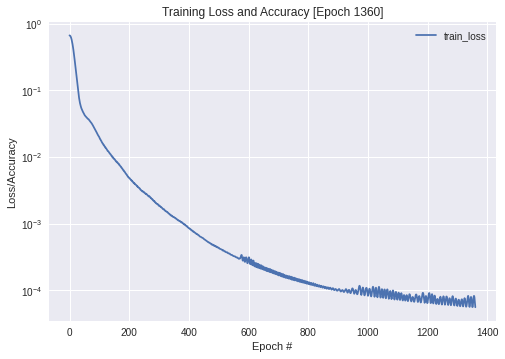

98/98 [==============================] - 0s 4ms/sample - loss: 5.5683e-05 - accuracy: 0.9975
Epoch 1362/10000
98/98 [==============================] - 0s 10us/sample - loss: 5.5730e-05 - accuracy: 0.9975
Epoch 1363/10000
98/98 [==============================] - 0s 12us/sample - loss: 6.1577e-05 - accuracy: 0.9975
Epoch 1364/10000
98/98 [==============================] - 0s 9us/sample - loss: 6.9797e-05 - accuracy: 0.9976
Epoch 1365/10000
98/98 [==============================] - 0s 11us/sample - loss: 7.6067e-05 - accuracy: 0.9976
Epoch 1366/10000
98/98 [==============================] - 0s 12us/sample - loss: 7.7450e-05 - accuracy: 0.9976
Epoch 1367/10000
98/98 [==============================] - 0s 9us/sample - loss: 7.2540e-05 - accuracy: 0.9976
Epoch 1368/10000
98/98 [==============================] - 0s 10us/sample - loss: 6.4793e-05 - accuracy: 0.9976
Epoch 1369/10000
98/98 [==============================] - 0s 13us/sample - loss: 5.7220e-05 - accuracy: 0.9976


KeyboardInterrupt: 

In [70]:
#log_dirCNN= model_locCNN + '/logs/' + date_time
#tensorboard_callbackCNN = tf.keras.callbacks.TensorBoard(log_dir=log_dirCNN, histogram_freq=100, update_freq='epoch')
#filepathCNN = model_locCNN + 'weights.{epoch:02d}.hdf5'
#checkpoint_callbackCNN = tf.keras.callbacks.ModelCheckpoint(filepathCNN, verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch',period=100)
start = timeit.default_timer()

mkpath(model_path)
checkpointHistory = tf.keras.callbacks.ModelCheckpoint(model_path+'intLoss{loss:.2E}.hdf5',
                                    monitor='loss', verbose=1, save_best_only=True, mode='auto',save_freq=10000)
checkpointLatest = tf.keras.callbacks.ModelCheckpoint(model_path+'latestTrainedModel.hdf5', monitor='loss', verbose=1,
    save_best_only=False, mode='auto',save_freq=500)  


csv_logger = CSVLogger(model_path + "log_loss.csv", append=True)
#filePath = 'model-lossSqrt-270K-150Sample.hdf5'
#mlModel=load_model(model_path+'latestTrainedModel.hdf5')
scaler1=np.zeros([cellCoeff.shape[0],2],float)
scaler1[:,1]=1.0
#print(scaler1)
init_epoch=10000
Force=np.zeros([X_train.shape[0],intrpAddr.shape[1],2])

bc=np.zeros([X_train.shape[0],bTrac.shape[1],2])


if (unsupervised):
    second_epoch=1000000
    init_one = np.ones([X_train.shape[0],X_train.shape[1],X_train.shape[2],2])
    if (inputName == 'cellCoeffs'):
        history = mlModel.fit([cellNei_train,cellCoeff_train,bFixed_train,bTrac_train,
                            case_init_loss[:n_train]],
                    Force, epochs=init_epoch,batch_size=1000,
                    callbacks=[checkpointHistory,checkpointLatest, csv_logger,plot_losses])
    else:
        history = mlModel.fit([inpData[:n_train],cellNei_train,cellCoeff_train,bFixed_train,bTrac_train,
                            case_init_loss[:n_train]],
                    Force, epochs=init_epoch,batch_size=1000,
                    callbacks=[checkpointHistory,checkpointLatest, csv_logger,plot_losses])
else:
    mlModel.fit(inpData[:n_train],disp_true_scaled[:n_train],epochs=init_epoch,batch_size=2560,callbacks=[plot_losses, csv_logger, checkpointLatest, checkpointHistory])

stop = timeit.default_timer()
print(stop-start)

In [71]:
#trainTime= stop-start
#os.rename(model_path + "log_loss.csv",model_path + "logLoss_Time=" + str(round(trainTime,1))+ "sec.csv")
print(mlModel.layers[2].moving_mean)
print(mlModel.layers[2].moving_variance)
#bn_gamma, bn_beta, bn_mean, bn_var = mlModel.layers[2].get_weights()
bn_mean, bn_var = mlModel.layers[2].get_weights()

print(bn_mean)
print(bn_var)
#print(bn_beta)
#print(bn_gamma)

<tf.Variable 'normaliztion_1/moving_mean:0' shape=(6000,) dtype=float32>
<tf.Variable 'normaliztion_1/moving_variance:0' shape=(6000,) dtype=float32>
[33.427975 56.04855   0.       ...  0.        0.        0.      ]
[ 46.192543 122.62125    0.       ...   0.         0.         0.      ]


In [72]:
def relErr(inp_data,nei,coeff,fix,trac,caseInit,rangeData,disp):

  n=0
  nei=nei.reshape(-1,nei.shape[1],nei.shape[2])
  coeff=coeff.reshape(-1,coeff.shape[1],coeff.shape[2],coeff.shape[3])
  fix=fix.reshape(-1,fix.shape[1],fix.shape[2])
  trac=trac.reshape(-1,trac.shape[1],trac.shape[2])

  caseInit=caseInit.reshape(-1,caseInit.shape[1],caseInit.shape[2])
  #rangeData = no_cell[n1:n2]
  disp = disp.reshape(-1,disp.shape[1],disp.shape[2])
    
  predictorModel = tf.keras.Model(inputs=mlModel.input,
                  outputs=mlModel.get_layer("foam_disp").output)

  if (unsupervised):
        if (inputName=='cellCoeffs'):
            y_res=predictorModel.predict([nei,coeff,fix,trac,caseInit])*rangeData
        else:
            y_res=predictorModel.predict([inp_data,nei,coeff,fix,trac,caseInit])*rangeData

    #loss_res=mlModel.predict([X[n1:n2],nei,coeff,fix,trac,intAdd,intWei,caseInit])
    #print(np.max(np.abs(loss_res[1])))

  else:
    y_res=scaler_y.inverse_transform(predictorModel.predict(inp_data).reshape([inp_data.shape[0],-1])).reshape([inp_data.shape[0],disp_true.shape[1],disp_true.shape[2]])
    #ml_output = predictorModel.predict(inpData[n1:n2])
    #y_res = tf.add(tf.multiply(tf.constant(scaler_y.scale_.reshape(ml_output.shape),tf.float32),ml_output),tf.constant(scaler_y.mean_.reshape(ml_output.shape),tf.float32),'final_out').eval(session=tf.compat.v1.Session())
    print(y_res.shape)
  magDPred=np.linalg.norm(y_res,axis=-1)
  magDTrue=np.linalg.norm(disp,axis=-1)
 
  disp_max_perCase= np.max(np.abs(magDTrue),axis=1).reshape(-1,1)
  rel_Err = np.abs(magDPred-magDTrue)/disp_max_perCase
  #print("\ny_predict=\n",y_res[1])#.reshape(-1,X.shape[1]*X.shape[2],y_res.shape[3]))
  #print('\ny_OF=\n',disp[1])
  maxMaxRelErr = np.max(rel_Err)*100
  meanMaxRelErr = np.mean(np.max(rel_Err,axis=0))*100
  print('For '+str(inp_data.shape[0])+' samples:')
  print("\nmeanError%=\n",np.mean(rel_Err)*100)
  print("\nmaxError%=\n",maxMaxRelErr)
  print("\nmeanMaxError%=\n",meanMaxRelErr)
  return meanMaxRelErr,maxMaxRelErr, y_res

nData=cellCoeff.shape[0]
print('training samples:')
trainMeanMaxRelErr,trainMaxRelErr, y_predict= relErr(inpData[0:n_train],cellNei[0:n_train],cellCoeff[0:n_train],bFixed[0:n_train],bTrac[0:n_train],case_init_loss[0:n_train],no_cell[0:n_train],disp_true[0:n_train])
try:
    print('\nvalidation samples:')
    trainMeanMaxRelErr,trainMaxRelErr, y_predict= relErr(inpData[n_train:nData],cellNei[n_train:nData],cellCoeff[n_train:nData],bFixed[n_train:nData],bTrac[n_train:nData],case_init_loss[n_train:nData],no_cell[n_train:nData],disp_true[n_train:nData])
except:
    print('No validation data!')

print('\ntesting samples:')
trainMeanMaxRelErr,trainMaxRelErr, y_predict= relErr(inpData_test,cellNei_test,cellCoeff_test,bFixed_test,bTrac_test,np.ones_like(disp_true_test),no_cell_test,disp_true_test)


training samples:
(98, 400, 3)
For 98 samples:

meanError%=
 0.19876814072372906

maxError%=
 8.427274935809557

meanMaxError%=
 1.1735169350368762

validation samples:
No validation data!

testing samples:
(20, 400, 3)
For 20 samples:

meanError%=
 0.7467918530726324

maxError%=
 14.897629868094928

meanMaxError%=
 2.9504590418076706


In [63]:
from tensorflow.compat.v1.keras.backend import get_session
import tensorflow.compat.v1 as tf1


mlModel2=BuildModel(False)
mlModel2.set_weights(mlModel.get_weights())
mlModel2.save(model_path+'latestTrainedModel.hdf5')
tf.keras.backend.clear_session()

mlModel = tf.keras.models.load_model(model_path+'latestTrainedModel.hdf5')

supervised_out_name = 'final_out'





ml_output = mlModel.get_layer("foam_disp").output

scaler_scale = tf.constant(scaler_y.scale_.reshape(1,ml_output.shape[1],ml_output.shape[2]),tf.float32)
scaler_mean = tf.constant(scaler_y.mean_.reshape(1,ml_output.shape[1],ml_output.shape[2]),tf.float32)

# for supervisedm method, we need to add a layer for inverse normalization the output of the model
final_out = tf.add(tf.multiply(scaler_scale,ml_output),scaler_mean,supervised_out_name)

current_graph = get_session().graph
all_names = [op.name for op in current_graph.get_operations()]
input_names = [s for s in all_names if 'Inp' in s]


output_names = [supervised_out_name]
predictive_file ='predictive_sup.pb'

if unsupervised:
    output_names = [tf.keras.Model(inputs=mlModel.input,outputs=mlModel.get_layer("foam_disp").output).outputs[0].op.name]
    predictive_file ='predictive_uns.pb'
export_names = np.concatenate([input_names,output_names],-1)


def freeze_session (session , keep_var_names =None , output_names =None , clear_devices =True):
    
    graph = session.graph
    with graph . as_default ():
        freeze_var_names = list(set(v.op.name for v in tf1.global_variables ()). difference (
    keep_var_names or []))
        output_names = []#output_names or []
        output_names += [v for v in export_names]#[v.op.name for v in tf1. global_variables ()]
        input_graph_def = graph . as_graph_def ()
        if clear_devices :
            for node in input_graph_def .node:
                node. device = ""
        frozen_graph = tf1.graph_util.convert_variables_to_constants(session,
                                                    input_graph_def , output_names , freeze_var_names )
        return frozen_graph
# Save the graph to disk
frozen_graph = freeze_session (get_session(),output_names =[ out.op.name for out in mlModel . outputs ])
tf1.train.write_graph(frozen_graph, './',predictive_file, as_text = False )

print("The inputs are: ",input_names)
print("The outputs are: ",output_names)



Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
The inputs are:  ['InputNet']
The outputs are:  ['final_out']


In [64]:
test_cases = glob(path+'/ml_dataset/test/*/')
for i in range(0, len(test_cases)):
    cmd_str = 'cp ' + predictive_file + '  ' + test_cases[i]
    os.system(cmd_str)
    

In [ ]:
tf.__version__